# Exploring School Performance Data with Python and Data Science using *k-means clustering*

In [ ]:
# install the nycschools package and its requirements
%pip install nycschools

In [2]:
# discover the data in your Google Drive, or download it to the local Colab
# if no suitable data is found
from nycschools import dataloader
dataloader.download_data();

## <u>Introduction</u>

In this tutorial, we will explore how to use Python and data science techniques to manipulate and analyze data related to school performance. Specifically, we will work with data from the New York City public school system, including school demographics and student performance on English Language Arts (ELA) and Math exams. We will use clustering analysis to identify patterns in the data and visualize the results using scatter plots.

### <u>Data Preparation</u>

To get started, we will load the necessary Python packages and install any missing dependencies using the %pip magic command:

In [3]:
%pip install nbformat
%pip install plotly

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


We will then import the necessary libraries for data manipulation, analysis, and visualization:

In [4]:
import pandas as pd
from nycschools import schools, exams

Next, we will load the school demographics and exam data using the schools and exams functions from the nycschools package:

In [5]:
demo = schools.load_school_demographics()
ela = exams.load_ela()
math = exams.load_math()


We will then merge the ELA and Math exam data based on common columns, and rename columns for clarity:

In [6]:
ela_math = pd.merge(ela, math, on=['dbn', 'grade','test_year', 'category'])
for col in ela_math.columns:
    if col.endswith('_x'):
        new_col_name = col.replace('_x', '_ela')
        ela_math = ela_math.rename(columns={col: new_col_name})
    elif col.endswith('_y'):
        new_col_name = col.replace('_y', '_math')
        ela_math = ela_math.rename(columns={col: new_col_name})


ela_math = ela_math[['dbn', 'ay_ela', 'test_year', 'grade', 'category', 'number_tested_ela', 'mean_scale_score_ela',
                      'number_tested_math', 'mean_scale_score_math']]

ela_math.rename(columns={ 'mean_scale_score_ela': 'mean_score_ela', 'ay_ela': 'ay', 'number_tested_ela': 'num_tested_ela','number_tested_math': 'num_tested_math', 'mean_scale_score_math': 'mean_score_math'}, inplace=True)


We will also select specific columns from the school demographics data and merge it with the ELA and Math exam data:

In [7]:
demo = demo[['dbn', 'beds', 'district', 'geo_district', 'boro', 'school_name',
       'short_name', 'ay', 'school_type', 'total_enrollment', 'zip', 'asian_pct', 
       'black_pct', 'hispanic_pct', 'multi_racial_pct','native_american_pct', 'white_pct']]
demo_math_ela = demo.merge(ela_math, on=["dbn", "ay"])

Lastly, we will rename the demo_math_ela dataframe to data and choose/reorder columns for analysis:

In [8]:
data = demo_math_ela[['dbn','beds', 'ay',
        'test_year','district', 'geo_district', 'boro', 'school_name',
       'short_name', 'school_type', 'zip', 'total_enrollment', 'asian_pct', 
       'black_pct', 'hispanic_pct', 'multi_racial_pct','native_american_pct', 'white_pct', 'category', 'grade', 'num_tested_ela',
       'mean_score_ela', 'num_tested_math', 'mean_score_math']]

### <u>Data Analysis</u>

Now that we have our data loaded and merged, we can start analyzing it. Our goal is to identify patterns in the data that can help us understand how different schools with similar student populations are performing.   

In the next cell, we will import all the necessary Python libraries for data analysis and visualization:

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

#### <u>Data Cleaning</u>

Before we can perform any analysis, we need to clean the data and prepare it for clustering. We will filter the data to only include observations from the 2018 school year, grade 5, and all students:

In [10]:
filtered_data = data[(data['test_year'] == 2018) & (data['grade'] == '4') & (data['category'] == 'All Students')]

We will then select the relevant columns for clustering:

In [11]:
cluster_data = filtered_data[['asian_pct', 'black_pct', 'hispanic_pct', 'multi_racial_pct', 'native_american_pct', 'white_pct']]

We will drop any missing values from the data and standardize the variables using StandardScaler to ensure that each variable has a mean of 0 and standard deviation of 1:

In [12]:
# drop rows with missing values
cluster_data = cluster_data.dropna()

# standardize the data
scaler = StandardScaler()
scaled_data = scaler.fit_transform(cluster_data)

#### <u>Clustering</u>

Clustering is an unsupervised machine learning technique that involves grouping similar observations together into clusters. The goal of clustering is to identify patterns and structure in the data, and to partition the data into groups based on similarity.

In this tutorial, we will use K-Means clustering to group schools based on student performance on ELA and Math exams. K-Means is a popular clustering algorithm that works by partitioning the data into K clusters, where K is a user-defined parameter. The algorithm starts by randomly assigning each observation to a cluster, and then iteratively updates the cluster centers and reassigns observations to the closest cluster until convergence.

Before we can perform clustering, we need to prepare the data by selecting relevant features and standardizing the variables. In this tutorial, we will select the percentages of students in each racial category (Asian, Black, Hispanic, Multi-Racial, Native American, and White) as the features for clustering. We will also standardize the data using StandardScaler to ensure that all variables have a mean of 0 and a standard deviation of 1.

To determine the optimal number of clusters for our data, we will use the elbow method. The elbow method involves plotting the within-cluster sum of squares (WCSS) as a function of the number of clusters, and selecting the number of clusters at the "elbow" of the curve. The elbow represents the point of diminishing returns, where adding more clusters does not significantly reduce the WCSS.

In this tutorial, we will use matplotlib.pyplot to create the elbow plot:


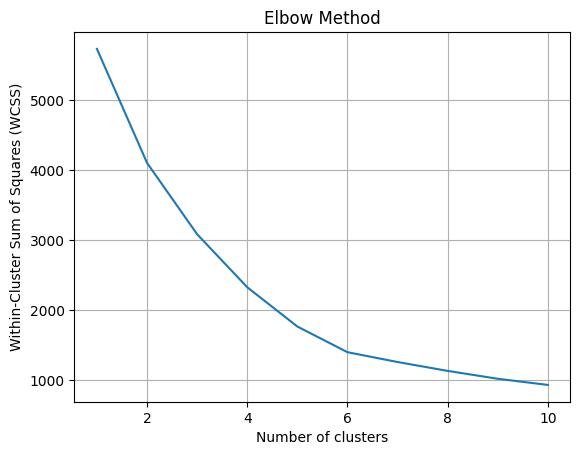

In [13]:
# Initialize an empty list to store the within-cluster sum of squares (WCSS)
wcss = []

# Set the range of possible cluster numbers to test
max_clusters = 10

for i in range(1, max_clusters + 1):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=42)
    kmeans.fit(scaled_data)
    wcss.append(kmeans.inertia_)

# Plot the elbow graph
plt.plot(range(1, max_clusters + 1), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('Within-Cluster Sum of Squares (WCSS)')
plt.grid(True)
plt.show()


Based on the elbow plot, we will choose 6 clusters for our analysis. We will then perform K-Means clustering on the scaled data using 6 clusters:

In [14]:
# Choose the optimal number of clusters (k) based on the elbow graph
k = 6

# Initialize the k-means model and fit it to the data
kmeans = KMeans(n_clusters=k, n_init=10, random_state=42)
kmeans.fit(scaled_data)

# Assign the cluster labels to each data point
cluster_labels = kmeans.labels_

We will add the cluster labels back to our filtered data:

In [16]:
filtered_data.loc[cluster_data.index, 'cluster'] = cluster_labels

#### <u>Data Visualization</u>

After clustering, we can visualize the results using scatter plots. Scatter plots are a useful visualization tool for exploring relationships between two continuous variables.

In this tutorial, we will create two scatter plots: one using matplotlib.pyplot and one using plotly.express. The matplotlib.pyplot scatter plot will show the relationship between mean Math and ELA scores for each cluster, while the plotly.express scatter plot will show the same information but with the addition of interactivity with school names and cluster labels.

Here's the code for the matplotlib.pyplot scatter plot:

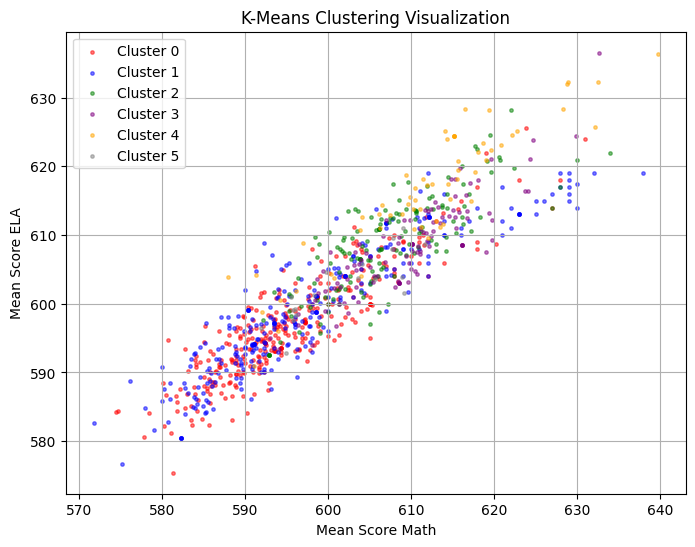

In [17]:
# Create a new DataFrame with the mean_score_ela, mean_score_math, and cluster labels
plot_data = filtered_data[['mean_score_ela', 'mean_score_math']].copy()
plot_data['Cluster'] = cluster_labels

# Visualize the clusters using a scatterplot
plt.figure(figsize=(8, 6))
colors = ['red', 'blue', 'green', 'purple', 'orange', 'gray', 'pink', 'cyan', 'brown', 'black']

for i in range(k):
    plt.scatter(plot_data.loc[plot_data['Cluster'] == i, 'mean_score_math'], plot_data.loc[plot_data['Cluster'] == i, 'mean_score_ela'], c=colors[i], label=f'Cluster {i}', s=6, alpha = 0.5)

plt.xlabel('Mean Score Math')
plt.ylabel('Mean Score ELA')
plt.title('K-Means Clustering Visualization')
plt.legend()
plt.grid(True)
plt.show();

And here's the code for the plotly.express scatter plot:

In [18]:
import plotly.express as px

# Create a new DataFrame with the mean_score_ela, mean_score_math, and cluster labels
plot_data = filtered_data[['school_name', 'mean_score_ela', 'mean_score_math']].copy()
plot_data['Cluster'] = cluster_labels
plot_data['Cluster'] = plot_data['Cluster'].astype(str)  # Convert cluster labels to strings for better display in the plot

# Sort the plot_data DataFrame by the 'Cluster' column
plot_data = plot_data.sort_values(by='Cluster')

# Create the interactive scatterplot
fig = px.scatter(plot_data, x='mean_score_math', y='mean_score_ela', color='Cluster', title='K-Means Clustering Visualization',
                 hover_data=['school_name', 'mean_score_math', 'mean_score_ela'], width=800, height = 600, size_max=8, opacity=0.5)

# Set x-axis and y-axis titles
fig.update_xaxes(title='Mean Score Math')
fig.update_yaxes(title='Mean Score ELA')

# Center the title
fig.update_layout(
    title={
        'text': 'K-Means Clustering Visualization',
        'x': 0.5
    }
)

# Show the interactive scatterplot
fig.show()


The `plotly.express` scatter plot has some additional features that are not present in the `matplotlib.pyplot` scatter plot. For example, the `plotly.express` plot includes school names and cluster labels in the hover data, which can be useful for identifying individual schools and understanding the patterns in the data.  Additionally, you are able to select and deselect clusters to improve visability.

Overall, clustering and visualization are powerful tools for analyzing data and identifying patterns and structure. By using K-Means clustering and scatter plots, we were able to identify 6 distinct clusters of schools based similarities in their student populations, and to visualize the relationship between mean Math and ELA scores for each cluster. These insights can be used to inform policy and practice in the education sector, and to support efforts to improve student outcomes.

### <u>Data Analysis</u>

#### <u>Cluster Summary Statistics</u>

After performing K-Means clustering on the data, we can calculate summary statistics for each cluster to better understand the characteristics of each group. In this tutorial, we will use `tabulate` to create a nicely formatted table of cluster summary statistics.




In [19]:
import tabulate

First, we will create a new DataFrame with only the numeric columns (i.e., the racial percentages and cluster labels) from our filtered data:

In [20]:
numeric_data = filtered_data[['asian_pct', 'black_pct', 'hispanic_pct', 'multi_racial_pct', 'native_american_pct', 'white_pct', 'cluster', 'mean_score_ela', 'mean_score_math']]

Next, we group the numeric_data DataFrame by cluster labels using the `groupby` method, and calculate the mean for each feature using the `mean` method:

In [21]:
cluster_summary = numeric_data.groupby('cluster').agg({
    'asian_pct': 'mean',
    'black_pct': 'mean',
    'hispanic_pct': 'mean',
    'multi_racial_pct': 'mean',
    'native_american_pct': 'mean',
    'white_pct': 'mean',
    'mean_score_ela': 'mean',
    'mean_score_math': 'mean'
})

In [22]:
cluster_summary = cluster_summary.reset_index()
cluster_summary

,cluster,asian_pct,black_pct,hispanic_pct,multi_racial_pct,native_american_pct,white_pct,mean_score_ela,mean_score_math
0,0.0,0.051938,0.186527,0.707450,0.005490,0.008173,0.039935,596.669298,595.251397
1,1.0,0.030381,0.680382,0.236706,0.008686,0.011256,0.032062,599.267711,598.022696
2,2.0,0.146550,0.072698,0.276034,0.019000,0.005174,0.479953,608.688885,607.104221
3,3.0,0.573324,0.048074,0.223778,0.011250,0.009046,0.134481,608.395874,609.675596
4,4.0,0.125323,0.124585,0.199062,0.079277,0.003692,0.466323,616.164470,611.932668
5,5.0,0.303056,0.306944,0.222444,0.010000,0.130222,0.027056,602.588040,601.767819


Finally, we will use `tabulate` to create a formatted table from the cluster_summary DataFrame.  The `tabulate.tabulate` function takes several arguments to customize the table formatting, including the table format ('fancy_grid' in this case), whether to show row indices (`True` in this case), and how to align numeric and string data (`numalign='center'` and `stralign='center'` in this case).

We also use the `str.format` method to format the numeric data in the table to 6 decimal places:

In [23]:
# Create a nicely formatted table from the cluster_summary DataFrame
table = tabulate.tabulate(cluster_summary, headers=cluster_summary.columns, tablefmt='fancy_grid', showindex=True, numalign='center', stralign='center')
table = table.format({col: '{.6f}' for col in cluster_summary.columns if col != 'Cluster'})


Finally, we print the table using the `print` function:

In [24]:
# Print the table
print('Cluster Summary Statistics\n')
print(table)


Cluster Summary Statistics

╒════╤═══════════╤═════════════╤═════════════╤════════════════╤════════════════════╤═══════════════════════╤═════════════╤══════════════════╤═══════════════════╕
│    │  cluster  │  asian_pct  │  black_pct  │  hispanic_pct  │  multi_racial_pct  │  native_american_pct  │  white_pct  │  mean_score_ela  │  mean_score_math  │
╞════╪═══════════╪═════════════╪═════════════╪════════════════╪════════════════════╪═══════════════════════╪═════════════╪══════════════════╪═══════════════════╡
│ 0  │     0     │  0.0519385  │  0.186527   │    0.70745     │     0.00549029     │       0.0081732       │  0.039935   │     596.669      │      595.251      │
├────┼───────────┼─────────────┼─────────────┼────────────────┼────────────────────┼───────────────────────┼─────────────┼──────────────────┼───────────────────┤
│ 1  │     1     │  0.0303809  │  0.680382   │    0.236706    │     0.00868586     │       0.0112561       │  0.0320623  │     599.268      │      598.023      │


The cluster summary statistics table provides insights into the demographic characteristics and academic performance of each cluster. Each row represents a cluster, and the columns show the mean percentage of students in each race/ethnicity category, as well as the mean ELA and Math scores for each cluster.  

For example, Cluster 0 has the highest percentage of Hispanic students (71%) and the lowest percentage of multiracial students (0.5%). This cluster obtained the lowest mean ELA score (597.0), and the lowest mean Math score (594.8).

Cluster 5 has the highest percentage of multiracial students (7.9%) and the lowest percentage of Native American students (0.3%), while having a relativerly high percentage of white students (47.6%). Cluster 5 obtained the greatest mean ELA score and the greatest mean Math score at 616.2 and 614.5, respectively.

These cluster summary statistics can be used to inform further analysis and decision-making, such as identifying areas for improvement and targeting resources to specific student populations.



